# Tests

In [1]:
Threads.nthreads()

4

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using PythonCall
using NPZ
using BenchmarkTools;

In [3]:
np = pyimport("numpy");

In [4]:
meta = np.load("../data/SD/SD_meta.npz")
tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [6]:
tracers_names

10-element Vector{String}:
 "DECALS__0_0"
 "DECALS__1_0"
 "DECALS__2_0"
 "DECALS__3_0"
 "KiDS1000__0_e"
 "KiDS1000__1_e"
 "KiDS1000__2_e"
 "KiDS1000__3_e"
 "KiDS1000__4_e"
 "PLAcv_k"

In [7]:
files = npzread("../data/SD/SD_files.npz");

In [8]:
path = "/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag/"
pars = np.loadtxt(string(path, "cl_cross_corr_v3_DES_K1000_all_mag_correctMag.bestfit"))
pars = pyconvert(Vector{Float64}, pars);


## 2D Lkl

In [18]:
[pars[28], pars[29], pars[30], pars[31]]

4-element Vector{Float64}:
 1.166097
 1.398773
 1.349232
 1.822822

In [16]:
function get_Xi2(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=inv_cov_tot, 
                 tk_mode="emulator")
    nuisances = Dict("A_IA" => pars[16],
                     "alpha_IA" => pars[17],

                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31],
                     #"DECALS__0_0_dz" => pars[32],
                     #"DECALS__1_0_dz" => pars[33],
                     #"DECALS__2_0_dz" => pars[34],
                     #"DECALS__3_0_dz" => pars[35],
                    
                     "KiDS1000__0_e_m" => pars[36],
                     "KiDS1000__1_e_m" => pars[37],
                     "KiDS1000__2_e_m" => pars[38],
                     "KiDS1000__3_e_m" => pars[39],
                     "KiDS1000__4_e_m" => pars[40],
                     "KiDS1000__0_e_dz" => pars[41],
                     "KiDS1000__1_e_dz" => pars[42],
                     "KiDS1000__2_e_dz" => pars[43],
                     "KiDS1000__3_e_dz" => pars[44],
                     "KiDS1000__4_e_dz" => pars[45])
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov_tot  * diff)

end

get_Xi2 (generic function with 1 method)

In [19]:
get_Xi2(0.3, 0.81, tk_mode="EisHu")

791.6866819835486

In [11]:
Ωms = LinRange(0.1, 0.6, 20)
s8s = LinRange(0.65, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.65,0.663158,0.676316,0.689474,0.702632,…,0.860526,0.873684,0.886842,0.9

In [59]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

20×20 Matrix{Float64}:
 8419.42  8064.28  7829.25  7726.9   7770.67  …  29669.4   33792.7   38409.5
 6618.7   6059.13  5595.54  5237.39  4994.65     18007.2   20789.8   23920.7
 5917.02  5242.43  4648.9   4144.18  3736.43     11775.5   13838.6   16179.5
 5662.61  4919.3   4247.28  3653.39  3144.7       8152.81   9785.5   11655.9
 5631.97  4845.78  4124.35  3473.82  2900.58      5947.09   7303.6    8872.98
 5716.66  4903.67  4150.82  3463.8   2848.57  …   4590.99   5764.59   7135.06
 5862.62  5032.86  4259.92  3549.2   2906.35      3765.89   4816.07   6052.69
 6016.12  5177.08  4392.64  3668.02  3008.66      3316.35   4289.45   5442.69
 6144.92  5302.89  4514.24  3784.11  3117.85      3163.28   4099.7    5213.51
 6255.03  5414.85  4627.62  3898.44  3232.62      3234.83   4164.95   5272.39
 6361.81  5527.19  4745.61  4022.19  3362.28  …   3478.51   4424.02   5548.7
 6485.04  5658.51  4885.43  4170.96  3520.49      3849.78   4824.46   5981.44
 6620.7   5804.54  5042.51  4339.82  3701.96  

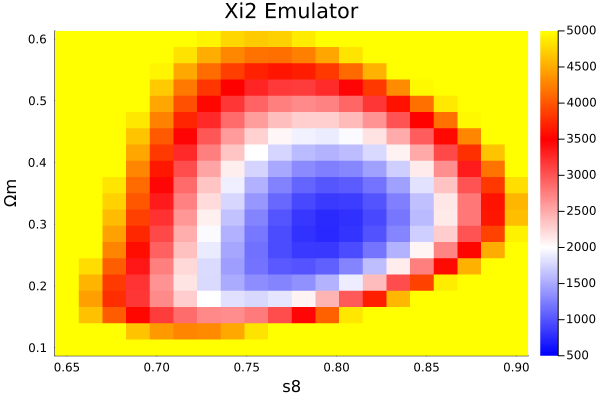

In [72]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_emul,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(500, 5000),
    title="Xi2 Emulator")

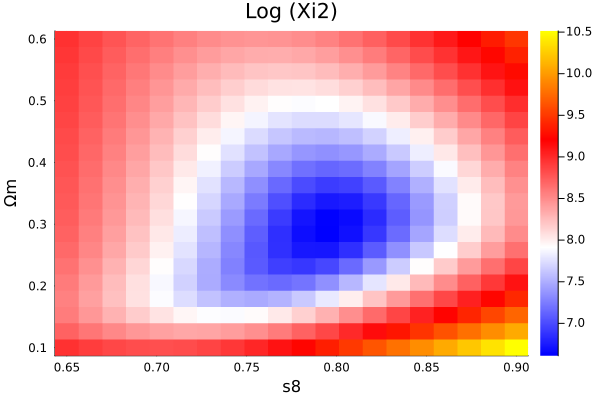

In [68]:
gr()
heatmap(s8s, Ωms, log.(Xi2s_emul),
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8",
    title="Log (Xi2)")